<a id='Introduction'></a>

<a id="section-one"></a>
# Introduction

![](https://www.cerillion.com/cerillioncom/media/cerillionMedia/BlogImages/PUBG-Mobile.png?ext=.png?width=350)**With this notebook, our goal is to build a regression equation to predict a players Win Place Percentile given different independent variables for the game PUBG.**

PUBG is a battle royale video game where multiple teams land on a map and fight each other until 1 team comes out victorious. There are multiple different game modes in PUBG including solos, duos, and squads. For simplicity of this model, I did not tailor my results to each match type which may provide more detail. My model explains PUBG as a whole and what independent variables have the highest impact on the Win Place Percentile of a team.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pubg-finish-placement-prediction/test_V2.csv
/kaggle/input/pubg-finish-placement-prediction/train_V2.csv
/kaggle/input/pubg-finish-placement-prediction/sample_submission_V2.csv


<a id="section-two"></a>
# Pre-Processing

Here in the pre-processing, we will upload our data and clean our data. The cleaning process includes checking for null values, removing outliers, and feature selection. 

In [2]:
train = pd.read_csv('../input/pubg-finish-placement-prediction/train_V2.csv')
test = pd.read_csv('../input/pubg-finish-placement-prediction/test_V2.csv')

In [3]:
"""
Wanted to first look at the different data types in the dataset to 
understand which features could be used in a regression equation
Since I am building a linear regression equation, I can't use any object types (categorical)
"""

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

Next step is exploring the features to see if there are any null values.

In [4]:
null_columns = train.columns[train.isnull().any()]
train[null_columns].isnull().sum()

winPlacePerc    1
dtype: int64

In [5]:
#Seeing how there is only 1 null in winPlacePerc I sorted the data to view what index the null occurs in.

train['winPlacePerc'].isnull().sort_values(ascending=False).head(10)

2744604     True
4446965    False
1482325    False
1482319    False
1482320    False
1482321    False
1482322    False
1482323    False
1482324    False
1482326    False
Name: winPlacePerc, dtype: bool

In [6]:
#Now we need to drop the values for index 2744604

train.drop([train.index[2744604]], inplace=True)

Now that we cleaned our data of null values, let's check for outliers in our dataset. To see this I created a dataframe that looks at all values within 3 standard deviations of the mean for each independent variable.

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

numVar = train.drop(['winPlacePerc', 'Id', 'groupId','matchId', 'matchType'], axis=1)
scaler.fit(numVar)

scaled_feat = pd.DataFrame(scaler.transform(numVar), columns = numVar.columns)
scaled_feat.head()

#Now that we have the equivalent Z scores for all of our variables,
#I wanted to find outliers in the features and potentially remove them

boolVal = (scaled_feat > 3) | (scaled_feat < -3)

Outliers = 0

for i in scaled_feat:
    boolVal_i = boolVal[boolVal[i] == True].sum()
    Outliers = Outliers + boolVal_i
    
print(Outliers)

"""
Where there are true values, shows us how many outliers we have
as these values are more than 3 standard deviations from the mean

Returning Outliers shows us there is a massive amount of values past 3 standard deviations.
According to the empirical rules, 99.7% of our data falls within 3 standard deviations from the mean. 

With this massive amount of outliers, we can't remove them as this would significantly alter
the results of the data as we would be reducing the size of our training set by too much. 

To conclude, we will not remove outliers.
"""


assists            380829
boosts             195410
damageDealt        336896
DBNOs              246003
headshotKills      181107
heals              203738
killPlace               0
killPoints              0
kills              353449
killStreaks        151623
longestKill        276898
matchDuration       13254
maxPlace                0
numGroups               0
rankPoints            374
revives            227774
rideDistance       226471
roadKills           26991
swimDistance        95488
teamKills          139714
vehicleDestroys     77766
walkDistance        51373
weaponsAcquired     59285
winPoints               0
dtype: int64


"\nWhere there are true values, shows us how many outliers we have\nas these values are more than 3 standard deviations from the mean\n\nReturning Outliers shows us there is a massive amount of values past 3 standard deviations.\nAccording to the empirical rules, 99.7% of our data falls within 3 standard deviations from the mean. \n\nWith this massive amount of outliers, we can't remove them as this would significantly alter\nthe results of the data as we would be reducing the size of our training set by too much. \n\nTo conclude, we will not remove outliers.\n"

As stated above, there are too many potential outliers. We can't remove any due to this issue of potentially altering the results of the dataset. So we can now move onto exploratory data analysis for feature selection. 

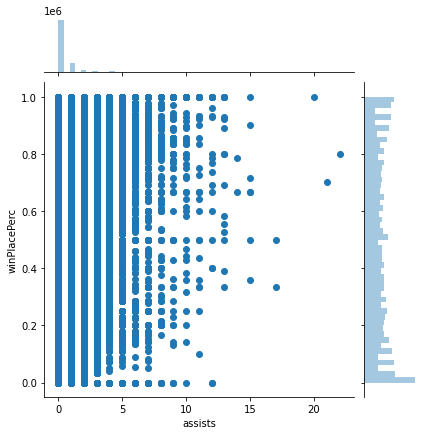

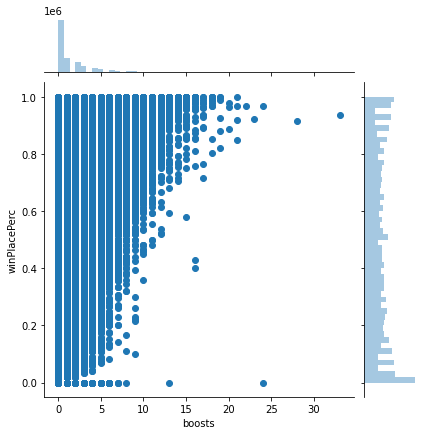

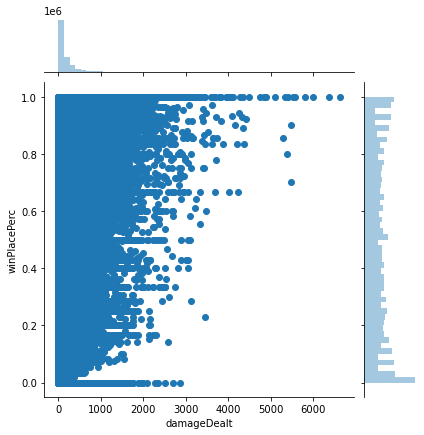

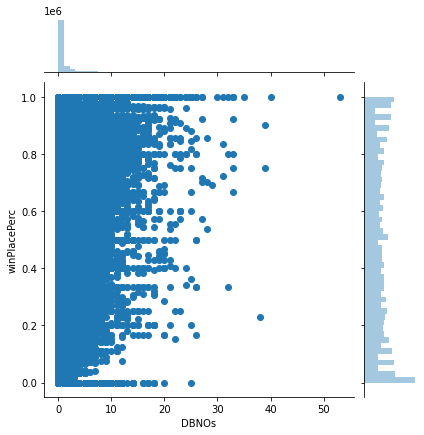

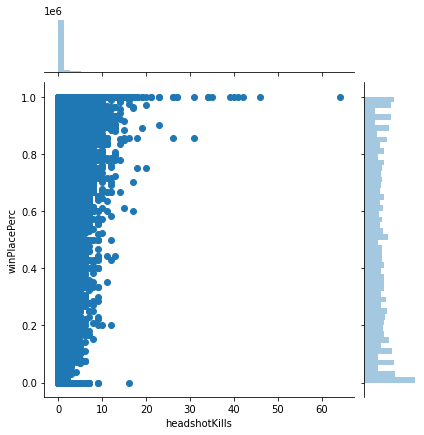

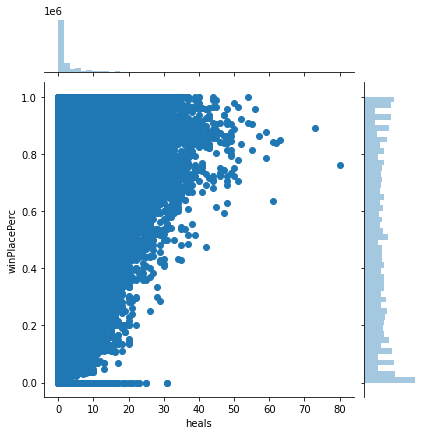

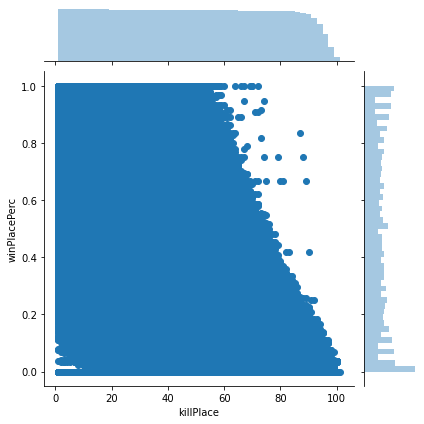

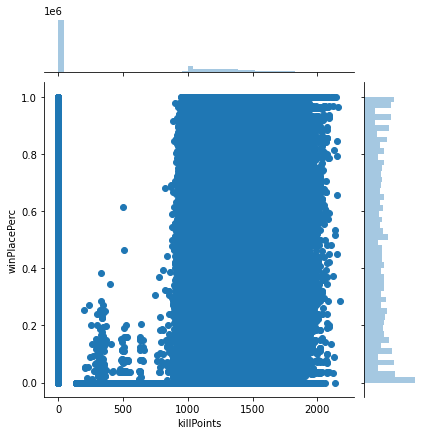

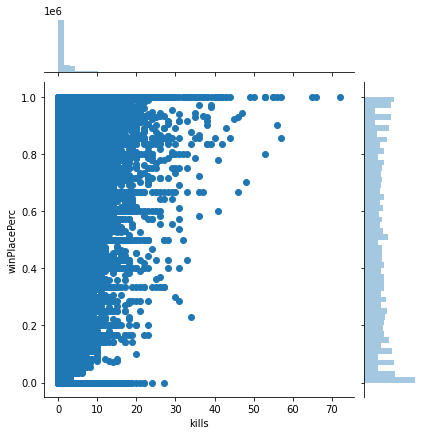

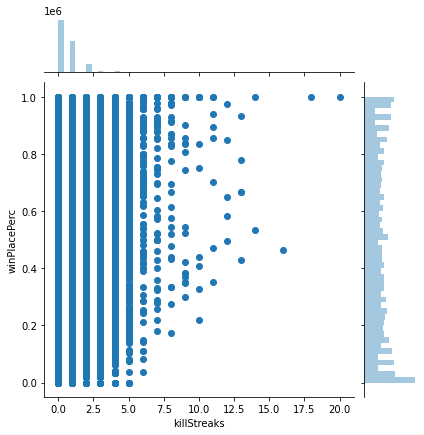

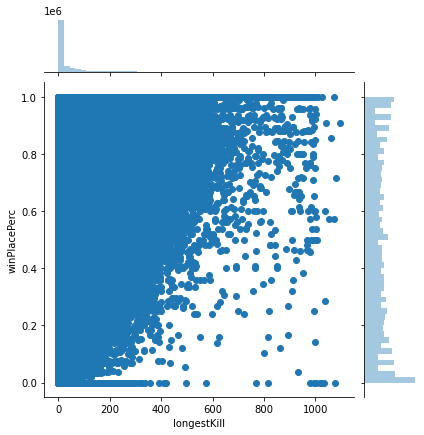

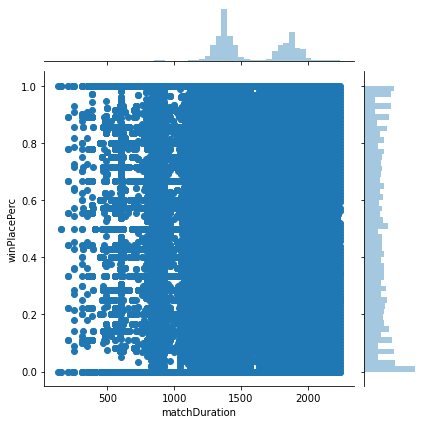

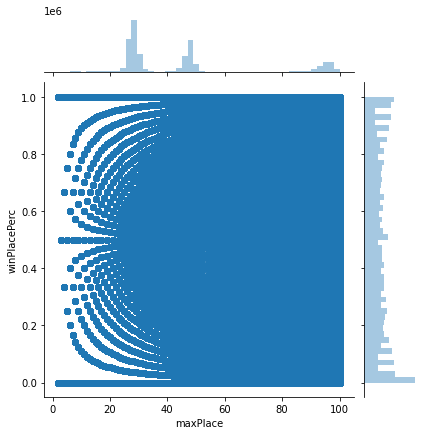

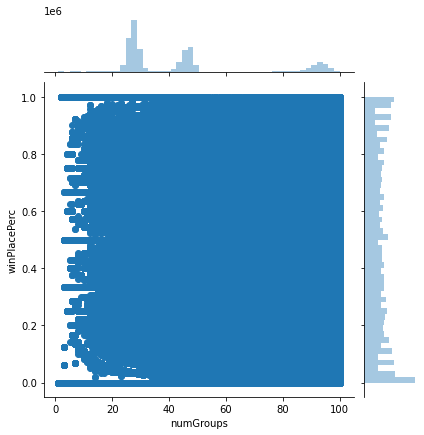

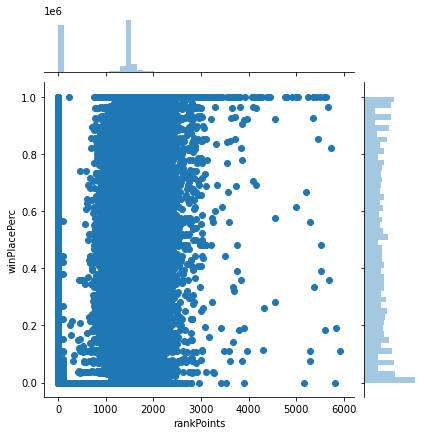

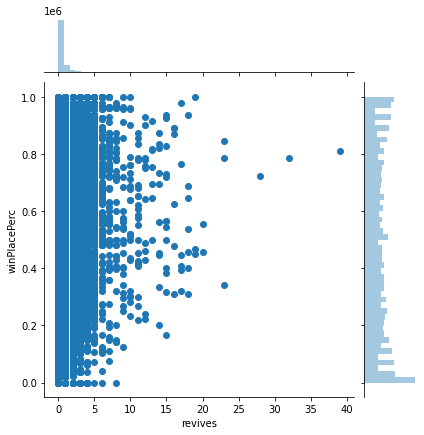

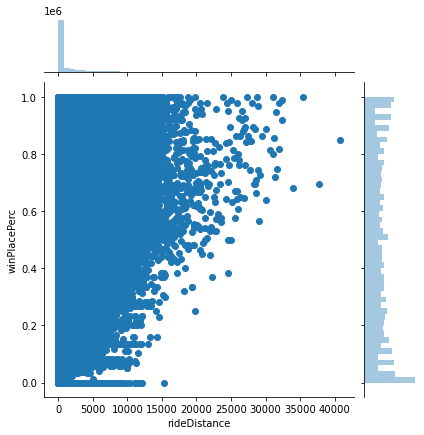

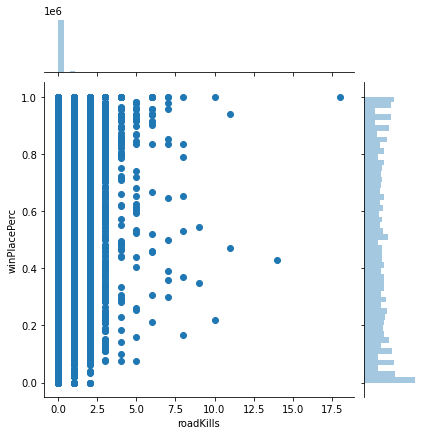

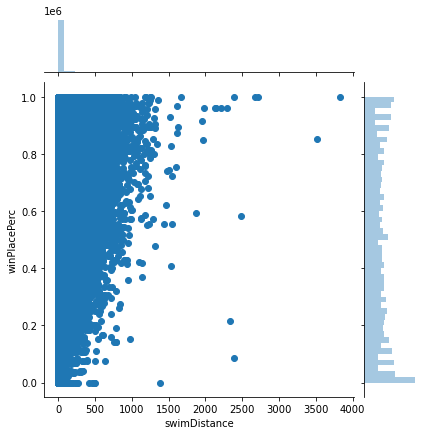

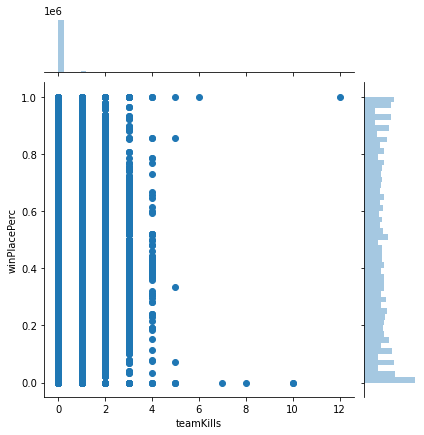

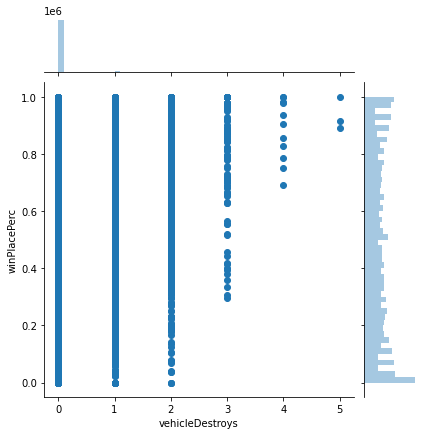

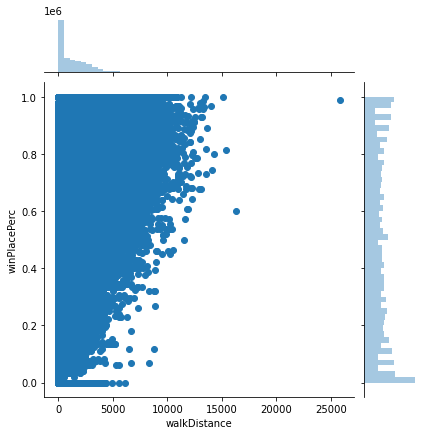

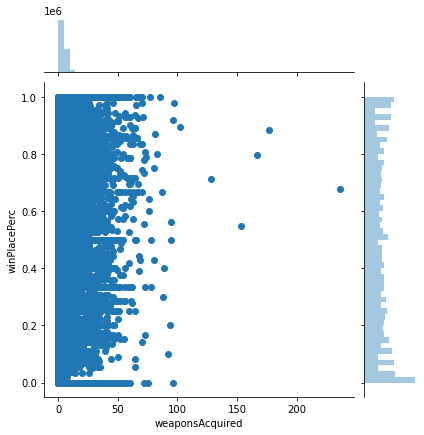

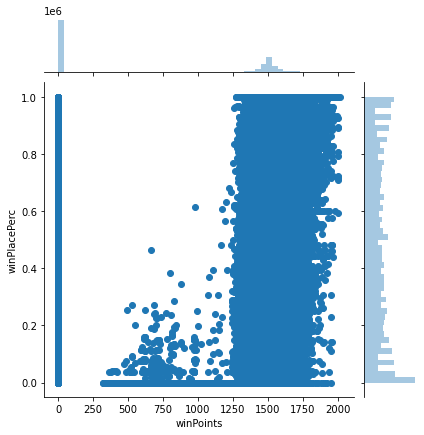

In [8]:
col = list(train.columns)
col = col[3:] #removes the 3 categorical variables that we can't
#use in a scatterplot
col.remove('winPlacePerc') #removes our dependent variables
col.remove('matchType') #remove another categorical variable

#using a for loop, we print out jointplots for each potential
#independent variables for our regression equation on the x axis and
#dependent varaible on our y axis
for i in col:
    sns.jointplot(x=i, y='winPlacePerc', data=train)
    plt.show()

Looking at the different jointplots above, we see a few variables that look to have some correlation with our winPlacePerc. These include: boosts, damageDealt, heals, killPlace, longestKill, rideDistance, and walkDistance. To analyze these specific variables further I built a heatmap to look at correlation values. 

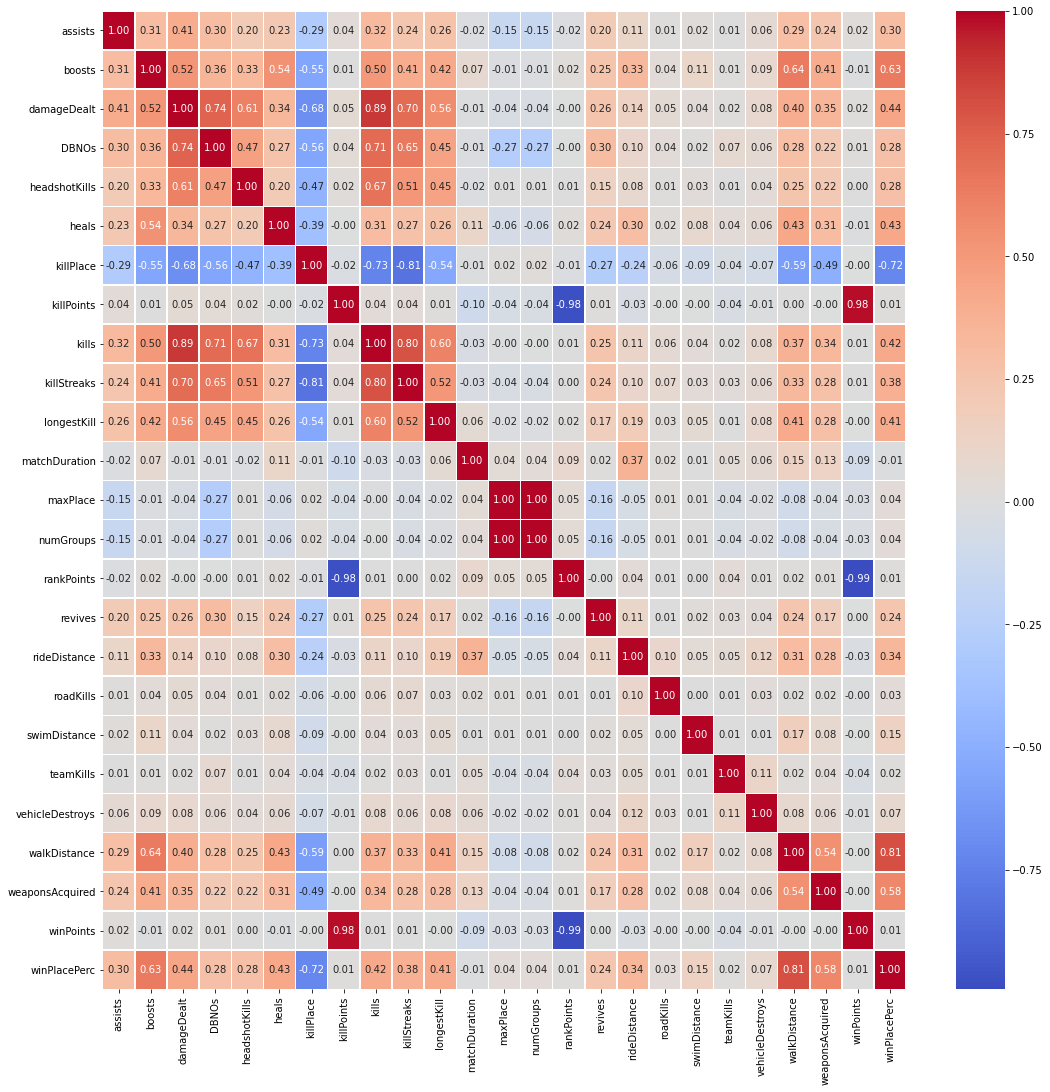

In [9]:
plt.figure(figsize=(18,18))
sns.heatmap(train.corr(), cmap='coolwarm', linecolor='white',
           linewidth=.5, annot=True, fmt='.2f')

Looking at the heatmap above I see that there are a few independent variables that have a strong correlation with winPlacePerc. Any absolute value of correlation above .5 I viewed as having a strong effect on the winPlacePerc. These included boosts (.63), killPlace (-.72), walkDistance (.81), and weaponsAcquired (.58). These are the independent variables that I will use in a linear regression equation.

<a id="section-four"></a>
# Model Creation

In [10]:
#Now we will train the model for linear regression
#First step is to seperate our independent variables and dependent variables

X = train[['killPlace', 'boosts', 'walkDistance', 'weaponsAcquired']]
y = train['winPlacePerc']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3)


Now that I have the training set split into a train and test model, I can use these variables to fit a linear regression equation. After fitting the regression equation to this training set, I can apply it to the test set and view the goodness of fit. 

In [11]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
linear.fit(X_train, y_train)

LinearRegression()

In [12]:
#Using the regression equation, we predict winPlacePerc off the 30% of data that our model hasn't seen before.
predictions=linear.predict(X_test)


To evaluate the goodness of fit, I used R^2. The resulting R^2 value of .7604 is rather good. This states that our linear regression equation explains approximately 76% of the variance in our data.

In [13]:
c_mat = np.corrcoef(y_test, predictions)
c_xy = c_mat[0,1]
r_squared = c_xy**2
print("R Squared: {:.4f}".format(r_squared))


R Squared: 0.7607


Now that we have a regression equation that is a rather good predictor on Win Placement, we apply this equation to our test dataset and then convert our predictions to a csv file.

In [14]:
X_test2 = test[['killPlace', 'boosts', 'walkDistance', 'weaponsAcquired']]
test_pred = linear.predict(X_test2)

results = pd.DataFrame(index=test['Id'], data=test_pred)
results.rename(columns={0: 'winPlacePerc'}, inplace=True)

results.to_csv('submission.csv')